# Praktikum 3


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import data...

In [5]:
   
def import_data(separator):
    """ This function is when you put together several datasets,
    but each dataset always starts with a time of 0.
    Input: dataframe that also has a column 't'
    Output: continuous time over all datasets
   """
    def time_norm(data):
        a = list(data.iloc[:]['t'])
        b = list(data.iloc[:]['t'])
        
        for u in range(len(a)-1):
            if a[u]>a[u+1]:
                if b[u]>b[u+1]:
                    offset = a[u]-a[u+1]+1
                    a[u+1] = offset + a[u+1]
                    u += 1
                else:
                    a[u+1] = offset + a[u+1]
                    u += 1
                      
        output = pd.DataFrame({'emg': data.emg, 't': a})
        output.reset_index(inplace = True, drop = True)
        return output
    
    """import data and put weights in one variable and mvc in one variable"""
    column_names = [
      'emg',
      't',  
    ]
    # Creating an empty Dataframe with column names only
    weights_raw = pd.DataFrame(columns=column_names)
    mvc_raw = pd.DataFrame(columns=column_names)
    fatigue_raw = pd.DataFrame(columns=column_names)
    
    # read all mvc, weight, and fatigue files 
    for i in range(3):
        # create string for path
        weights_string = 'Weight' + str(i+1) + '.txt'
        mvc_string = 'MVC' + str(i+1) + '.txt'
        fatigue_string = 'Fatique' + str(i+1) + '.txt'
        
        weights_raw = pd.concat([weights_raw, pd.read_csv(
            weights_string,
             sep=separator, names=column_names, skiprows= 50,
             skipfooter = 50,
             engine='python'
            )], ignore_index=True)
        mvc_raw = pd.concat([mvc_raw, pd.read_csv(
            mvc_string,
             sep=separator, names=column_names, skiprows= 50, 
             skipfooter = 50,
             engine='python'
            )], ignore_index=True)
        fatigue_raw = pd.concat([fatigue_raw, pd.read_csv(
            fatigue_string,
             sep=separator, names=column_names, skiprows= 50, 
             skipfooter = 50,
             engine='python'
            )], ignore_index=True)
    # timing needs changing as, the appended data starts from 0 again
    weights = time_norm(weights_raw)
    mvc = time_norm(mvc_raw)
    fatigue = time_norm(fatigue_raw)
    return weights, mvc, fatigue

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/MVC1.txt'

In [6]:
weights, mvc, fatigue = import_data('\t')

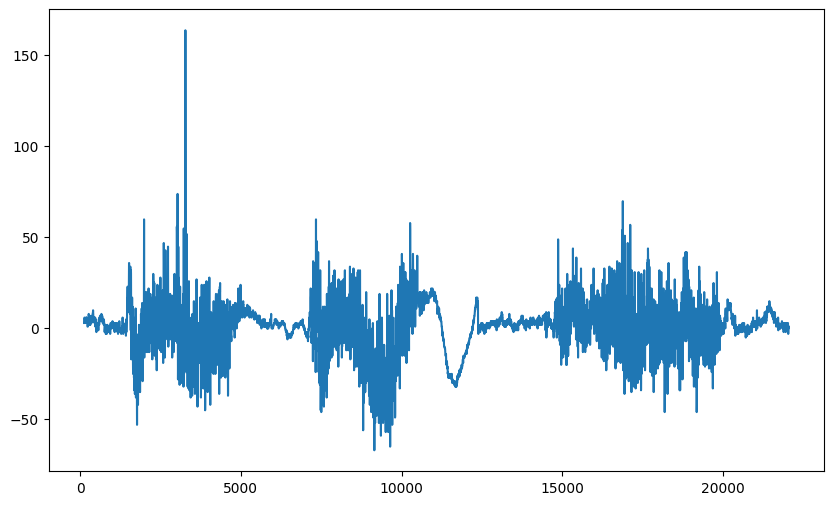

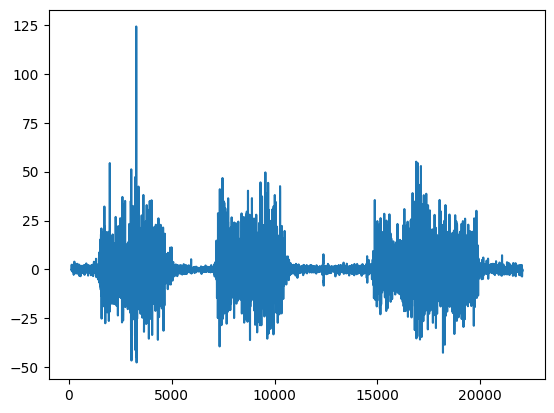

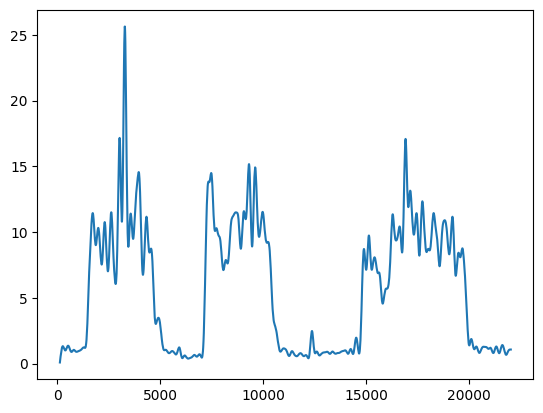

C:\Users\andih\AppData\Local\Temp\ipykernel_16580\1981964680.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


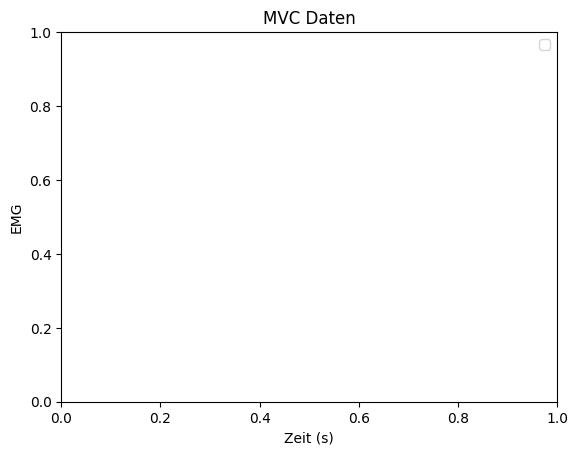

In [12]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Funktionen zum Einlesen und Normalisieren der Daten
def import_data(files, separator):
    def normalize_time(data):
        times = data['t'].values
        offset = 0
        for i in range(1, len(times)):
            if times[i] < times[i - 1]:
                offset += times[i - 1]
            times[i] += offset
        data['t'] = times
        return data

    all_data = []
    for file in files:
        df = pd.read_csv(file, sep=separator, names=['emg', 't'], skiprows=50, skipfooter=50, engine='python')
        df = normalize_time(df)
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Hoch- und Tiefpassfilter definieren
def butterworth_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low')
    return signal.filtfilt(b, a, data)

# Hauptverarbeitungsschritte
def process_emg_data(data, fs=1000):
    # Offset entfernen
    data['emg'] = data['emg'] - np.mean(data['emg'])

    # Bandpassfiltern (20-450 Hz)
    data['filtered_emg'] = butterworth_filter(data['emg'], 20, 450, fs)

    # Signal gleichrichten (Absolutwert bilden)
    data['rectified_emg'] = np.abs(data['filtered_emg'])

    # Tiefpassfilter auf den Absolutwert anwenden (10 Hz)
    data['envelope'] = lowpass_filter(data['rectified_emg'], 10, fs)

    return data




# EMG-Daten verarbeiten
mvc_processed = process_emg_data(mvc)


# Ergebnisse plotten
def plot_emg(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data['t'], data['emg'], label='Rohsignal')
    plt.show()
    plt.plot(data['t'], data['filtered_emg'], label='Gefiltert')
    plt.show()
    plt.plot(data['t'], data['envelope'], label='Einhüllende')
    plt.show()
    plt.title(title)
    plt.xlabel('Zeit (s)')
    plt.ylabel('EMG')
    plt.legend()
    plt.show()

plot_emg(mvc_processed, 'MVC Daten')



Note: you may need to restart the kernel to use updated packages.


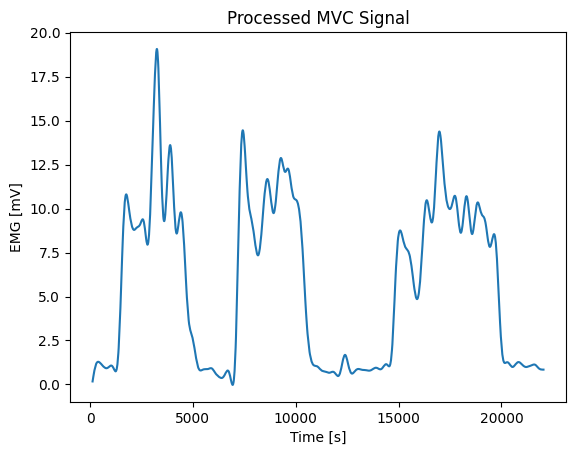

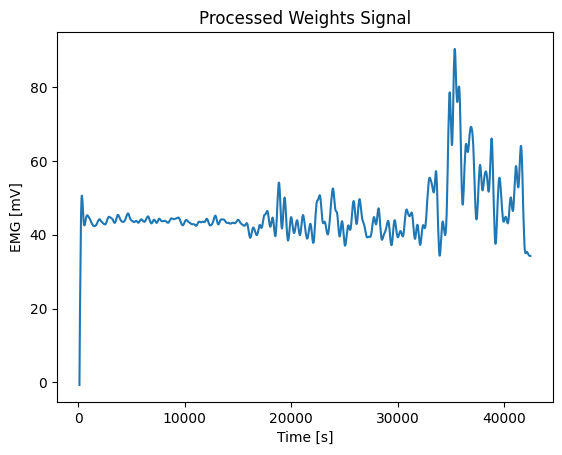

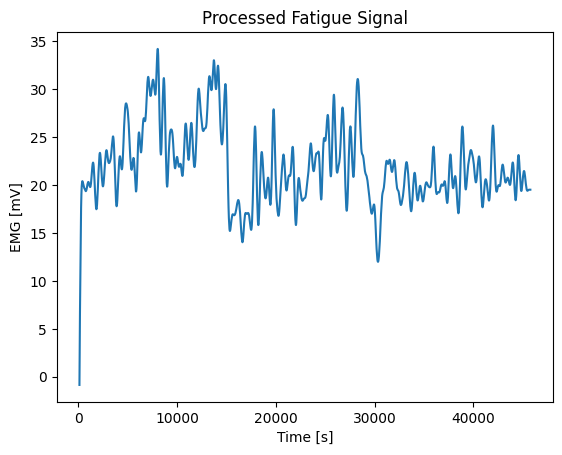

Mean EMG activity for MVC: 5.76 mV
Mean EMG activity for Weights: 45.78 mV
Mean EMG activity for Fatigue: 21.98 mV


In [1]:
%pip install scipy

import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
# Funktion zur Offset-Eliminierung
def remove_offset(emg_signal):
    return emg_signal - np.mean(emg_signal)

# Funktion zum Filtern des Signals (Butterworth Bandpass 20-450 Hz)
def bandpass_filter(emg_signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, emg_signal)

# Funktion zur Gleichrichtung des Signals
def rectify_signal(emg_signal):
    return np.abs(emg_signal)

# Funktion zur Bildung der Einhüllenden (Lowpass-Filter)
def envelope(emg_signal, cutoff, fs):
    nyquist = 0.5 * fs
    low = cutoff / nyquist
    b, a = butter(4, low, btype='low')
    return filtfilt(b, a, emg_signal)

# Funktion, um Daten zu importieren
def import_data(separator):
    def time_norm(data):
        a = list(data.iloc[:]['t'])
        b = list(data.iloc[:]['t'])
        
        for u in range(len(a)-1):
            if a[u]>a[u+1]:
                if b[u]>b[u+1]:
                    offset = a[u]-a[u+1]+1
                    a[u+1] = offset + a[u+1]
                    u += 1
                else:
                    a[u+1] = offset + a[u+1]
                    u += 1
                       
        output = pd.DataFrame({'emg': data.emg, 't': a})
        output.reset_index(inplace = True, drop = True)
        return output
    
    column_names = ['emg', 't']
    
    # Erstellen eines leeren DataFrames
    weights_raw = pd.DataFrame(columns=column_names)
    mvc_raw = pd.DataFrame(columns=column_names)
    fatigue_raw = pd.DataFrame(columns=column_names)
    
    # Daten einlesen
    for i in range(3):
        weights_string = 'Weight' + str(i+1) + '.txt'
        mvc_string = 'MVC' + str(i+1) + '.txt'
        fatigue_string = 'Fatique' + str(i+1) + '.txt'
        
        weights_raw = pd.concat([weights_raw, pd.read_csv(weights_string, sep=separator, names=column_names, skiprows=50, skipfooter=50, engine='python')], ignore_index=True)
        mvc_raw = pd.concat([mvc_raw, pd.read_csv(mvc_string, sep=separator, names=column_names, skiprows=50, skipfooter=50, engine='python')], ignore_index=True)
        fatigue_raw = pd.concat([fatigue_raw, pd.read_csv(fatigue_string, sep=separator, names=column_names, skiprows=50, skipfooter=50, engine='python')], ignore_index=True)
    
    weights = time_norm(weights_raw)
    mvc = time_norm(mvc_raw)
    fatigue = time_norm(fatigue_raw)
    return weights, mvc, fatigue

# Laden der Daten
weights, mvc, fatigue = import_data('\t')

# Sampling-Frequenz (zum Beispiel 1000 Hz)
fs = 1000

# Daten vorverarbeiten (Offset entfernen, filtern, gleichrichten und Einhüllende bilden)
# Für MVC
mvc.emg = remove_offset(mvc.emg)
mvc.emg = bandpass_filter(mvc.emg, 20, 450, fs)
mvc.emg = rectify_signal(mvc.emg)
mvc.emg = envelope(mvc.emg, 5, fs)

# Für Weights
weights.emg = remove_offset(weights.emg)
weights.emg = bandpass_filter(weights.emg, 20, 450, fs)
weights.emg = rectify_signal(weights.emg)
weights.emg = envelope(weights.emg, 5, fs)

# Für Fatigue
fatigue.emg = remove_offset(fatigue.emg)
fatigue.emg = bandpass_filter(fatigue.emg, 20, 450, fs)
fatigue.emg = rectify_signal(fatigue.emg)
fatigue.emg = envelope(fatigue.emg, 5, fs)

# Plots der vorverarbeiteten Daten
plt.figure()
plt.plot(mvc.t, mvc.emg)
plt.xlabel('Time [s]')
plt.ylabel('EMG [mV]')
plt.title('Processed MVC Signal')
plt.show()

plt.figure()
plt.plot(weights.t, weights.emg)
plt.xlabel('Time [s]')
plt.ylabel('EMG [mV]')
plt.title('Processed Weights Signal')
plt.show()

plt.figure()
plt.plot(fatigue.t, fatigue.emg)
plt.xlabel('Time [s]')
plt.ylabel('EMG [mV]')
plt.title('Processed Fatigue Signal')
plt.show()

# Berechnung der mittleren EMG-Aktivität für MVC, Weights und Fatigue
mvc_mean = np.mean(mvc.emg)
weights_mean = np.mean(weights.emg)
fatigue_mean = np.mean(fatigue.emg)

print('Mean EMG activity for MVC: {:.2f} mV'.format(mvc_mean))
print('Mean EMG activity for Weights: {:.2f} mV'.format(weights_mean))
print('Mean EMG activity for Fatigue: {:.2f} mV'.format(fatigue_mean))


2. gemittelte Daten von MVC berechnen und in ein csv datei abspeichern (ohne Berücksichtigung der 1. import data...)

In [9]:
def read_txt_file(filepath):
    return np.loadtxt(filepath)

def pad_data_to_max_length(*datasets):
    max_length = max(len(dataset) for dataset in datasets)
    padded_datasets = [
        np.pad(dataset, ((0, max_length - len(dataset)), (0, 0)), mode='constant', constant_values=0)
        for dataset in datasets
    ]
    return padded_datasets

def calculate_average_data(*datasets):
    return np.mean(datasets, axis=0)

def process_personal_data(filepaths, output_csv):
    # Daten einlesen
    datasets = [read_txt_file(filepath) for filepath in filepaths]
   
    # Daten auf gleiche Länge polstern
    padded_datasets = pad_data_to_max_length(*datasets)
    
    # Mittelwert berechnen
    average_data = calculate_average_data(*padded_datasets)
    
    # Ergebnis als DataFrame speichern
    average_df = pd.DataFrame(average_data, columns=['Value', 'Time'])
    average_df.to_csv(output_csv, index=False)
    print(f"Durchschnittsdaten gespeichert in: {output_csv}")

person1_files = ["MVC_1_Andreas.txt", "MVC_2_Andreas.txt", "MVC_3_Andreas.txt", "MVC_4_Andreas.txt"]
person2_files = ["MVC_1_Carina.txt", "MVC_2_Carina.txt", "MVC_3_Carina.txt", "MVC_4_Carina.txt"]
person3_files = ["MVC_1_Pauline.txt", "MVC_2_Pauline.txt", "MVC_3_Pauline.txt", "MVC_4_Pauline.txt"]

# Verarbeitung der Daten von Andreas
process_personal_data(person1_files, "average_MVC_Andreas.csv")

# Verarbeitung der Daten von Clara
process_personal_data(person2_files, "average_MVC_Carina.csv")

# Verarbeitung der Daten von Pauline
process_personal_data(person3_files, "average_MVC_Pauline.csv")


Durchschnittsdaten gespeichert in: average_MVC_Andreas.csv


FileNotFoundError: MVC_1_Carina.txt not found.

In [16]:
def get_bursts(mvc_emg_filtered, weights_emg_filtered, fatigue_emg_filtered):   
    def get_individual_burst(x):
        def tellme(s):
            print(s)
            plt.title(s, fontsize=16)
            plt.draw()
            
        plt.clf()
        plt.setp(plt.gca(), autoscale_on=True)
        plt.plot(x)
       
        tellme('Click once to start zoom')
        plt.waitforbuttonpress()
        
        while True:
            tellme('Select two corners of zoom, enter/return key to finish')
            pts = plt.ginput(2, timeout=-1)
            if len(pts) < 2:
                break
            (x0, y0), (x1, y1) = pts
            xmin, xmax = sorted([x0, x1])
            ymin, ymax = sorted([y0, y1])
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
          
            
        tellme('Choose start of activity')    
        s = plt.ginput(1)
        tellme('Choose end of activity')   
        e = plt.ginput(1)
        s1 = s[0]
        e1 = e[0]
        start = int(s1[0].astype(int))
        end = int(e1[0].astype(int))
        plt.show()
        
        return start,end
    number_bursts = 3
    mvc_start = np.empty(number_bursts)
    mvc_end = np.empty(number_bursts)
    weights_start = np.empty(number_bursts)
    weights_end = np.empty(number_bursts)
    fatigue_start = np.empty(number_bursts)
    fatigue_end = np.empty(number_bursts)
    for i in range(number_bursts):
        mvc_start[i], mvc_end[i] = get_individual_burst(mvc_emg_filtered)
    for i in range(number_bursts): 
        weights_start[i], weights_end[i] = get_individual_burst(weights_emg_filtered)
    for i in range(number_bursts): 
        fatigue_start[i], fatigue_end[i] = get_individual_burst(fatigue_emg_filtered)  
       
    mvc_start = mvc_start.astype(int)
    mvc_end = mvc_end.astype(int)
    weights_start = weights_start.astype(int)
    weights_end = weights_end.astype(int)
    fatigue_start = fatigue_start.astype(int)
    fatigue_end = fatigue_end.astype(int)
    
    
    return mvc_start, mvc_end, weights_start, weights_end, fatigue_start, fatigue_end